# Реализация метода стилизации $\text{RAST}$

[RAST paper](https://openaccess.thecvf.com/content/WACV2023/papers/Ma_RAST_Restorable_Arbitrary_Style_Transfer_via_Multi-Restoration_WACV_2023_paper.pdf)

### Загрузка модулей

In [1]:
import torch
import pandas as pd
import openpyxl
import uuid
from pathlib import Path
import random
import numpy as np
import datetime
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision import models
from torchvision.models import VGG19_Weights
from torchvision.utils import save_image
from typing import Tuple, Dict, List, Type
from torch.utils.data.sampler import Sampler
import os
from fastprogress.fastprogress import progress_bar
from time import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.optim.lr_scheduler import _LRScheduler, ReduceLROnPlateau
import copy
import ipywidgets as widgets
from abc import ABC, abstractmethod
import gc


%matplotlib inline
%config InlineBackend.figure_format = "svg"
os.environ['KAGGLE_CONFIG_DIR'] = os.path.expanduser('~/.kaggle')
Image.MAX_IMAGE_PIXELS = None  # Disable DecompressionBombError
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Disable OSError: image file is truncated

### Реализация энкодера  

In [2]:
vgg19 = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features

In [3]:
vgg19

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
vgg19_params = 0
for param in vgg19.parameters():
    vgg19_params += param.numel()
print(vgg19_params)

20024384


In [5]:
class VGG19Encoder(nn.Module):

    def __init__(self, vgg: nn.Sequential) -> None:
        super().__init__()
        self.block_names = ['relu_1_1', 'block1_rest', 
                            'relu_2_1', 'block2_rest',
                            'relu_3_1', 'block3_rest',
                            'relu_4_1', 'block4_rest',
                            'relu_5_1', 'block5_rest']
        self._assign_blocks(vgg)
        for name in self.block_names:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    def _assign_blocks(self, vgg: nn.Sequential) -> None:
        block_indices = {
            'relu_1_1': (None, 2), 'block1_rest': (2, 5),
            'relu_2_1': (5, 7), 'block2_rest': (7, 10),
            'relu_3_1': (10, 12), 'block3_rest': (12, 19),
            'relu_4_1': (19, 21), 'block4_rest': (21, 28),
            'relu_5_1': (28, 30), 'block5_rest': (30, None)}

        for block_name, (start, end) in block_indices.items():
            setattr(self, block_name, self._create_block(vgg, start, end))

    def _create_block(self, vgg: nn.Sequential, start: int, end: int) -> nn.Sequential:
        start = 0 if start is None else start
        end = len(vgg) if start is None else end
        return nn.Sequential(*vgg[start:end])

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        features = {}
        blocks = [
            (None, 'relu_1_1'),
            ('block1_rest', 'relu_2_1'),
            ('block2_rest', 'relu_3_1'),
            ('block3_rest', 'relu_4_1'),
            ('block4_rest', 'relu_5_1'),
            ('block5_rest', None),
        ]

        for block_rest, relu_block in blocks:
            if block_rest is not None:
                x = getattr(self, block_rest)(x)
            if relu_block is not None:
                x = getattr(self, relu_block)(x)
                features[relu_block] = x
        return features


In [6]:
class PretrainedVGG19Encoder(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self._config = [[(3, 1), 'RP', 64, 'RELU'], 
                        ['RP', 64, 'RELU', 'MAXPOOL', 'RP', 128, 'RELU'], 
                        ['RP', 128, 'RELU', 'MAXPOOL', 'RP', 256, 'RELU'], 
                        ['RP', 256, 'RELU', 'RP', 256, 'RELU', 'RP', 256, 'RELU', 'MAXPOOL', 'RP', 512, 'RELU'], 
                        ['RP', 512, 'RELU', 'RP', 512, 'RELU', 'RP', 512, 'RELU', 'MAXPOOL', 'RP', 512, 'RELU'], 
                        ['RP', 512, 'RELU', 'RP', 512, 'RELU', 'RP', 512, 'RELU']]
        self._block_names = ['relu_1_1', 'relu_2_1', 'relu_3_1', 'relu_4_1', 'relu_5_1', 'rest']
        self._assign_blocks()

    def _assign_blocks(self, init_channels: int = 3):
        blocks = []
        config_dict = {'RP': nn.ReflectionPad2d((1, 1, 1, 1)), 
                       'RELU': nn.ReLU(), 
                       'MAXPOOL': nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True)}
        for name, config in zip(self._block_names, self._config):
            for value in config:
                if isinstance(value, str):
                    blocks.append(config_dict[value])
                elif isinstance(value, tuple):
                    blocks.append(nn.Conv2d(init_channels, value[0], (value[1], value[1])))
                    init_channels = value[0]
                elif isinstance(value, int):
                    blocks.append(nn.Conv2d(init_channels, value, (3, 3)))
                    init_channels = value
            setattr(self, f'_{name}', nn.Sequential(*blocks))
            blocks = []

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        features = dict()
        for block_name in self._block_names[:-1]:
            x = getattr(self, f'_{block_name}')(x)
            features[block_name] = x
        return features
    

### Реализация декодера

In [7]:
class VGG19Decoder(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.config = [256, 'U', 256, 256, 256, 128, 'U', 128, 64, 'U', 64]
        self._decoder_model = self._assign_blocks()

    def _assign_blocks(self, channels: int = 512, end_channels: int = 3) -> nn.Sequential:
        blocks = []
        for value in self.config:
            if value == 'U':
                blocks.extend([nn.Upsample(scale_factor=2, mode='nearest')])
            elif isinstance(value, int):
                blocks.extend([nn.ReflectionPad2d((1, 1, 1, 1)),
                               nn.Conv2d(channels, value, kernel_size=3),
                               nn.ReLU(inplace=True)])
                channels = value
        blocks.extend([nn.ReflectionPad2d((1, 1, 1, 1)),
                       nn.Conv2d(channels, end_channels, kernel_size=3)])
        return nn.Sequential(*blocks)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._decoder_model(x)


### Реализация использующейся в архитектуре $\text{SANet}$

[SANet paper](https://openaccess.thecvf.com/content_CVPR_2019/papers/Park_Arbitrary_Style_Transfer_With_Style-Attentional_Networks_CVPR_2019_paper.pdf)

In [8]:
class SANet(nn.Module):

    def __init__(self, in_channels: int, use_conv: bool = True) -> None:
        super().__init__()
        self.use_conv = use_conv
        names_list = ['f', 'g', 'h'] if not use_conv else ['f', 'g', 'h', 'out_conv']
        for name in names_list:
            setattr(self, name, nn.Conv2d(in_channels, in_channels, kernel_size=1))

    def _normalize(self, f_maps: torch.Tensor) -> torch.Tensor:
        tol = 1e-10
        mean = torch.mean(f_maps, dim=(2, 3), keepdim=True)
        std = torch.std(f_maps, dim=(2, 3), keepdim=True)
        return (f_maps - mean) / (std + tol)

    def forward(self, content: torch.Tensor,
                style: torch.Tensor) -> torch.Tensor:
        batch, channels = content.shape[:2]
        f_content = self.f(self._normalize(content))
        g_style = self.g(self._normalize(style))
        h_style = self.h(style).view(batch, channels, -1)
        fg_product = torch.bmm(f_content.view(batch, channels, -1).permute(0, 2, 1), 
                               g_style.view(batch, channels, -1))
        f_softmax = F.softmax(fg_product, dim=-1).permute(0, 2, 1)
        f_cs = torch.bmm(h_style, f_softmax).view(*content.shape)

        return f_cs if not self.use_conv else self.out_conv(f_cs) + content


In [9]:
class SANetWrapper(nn.Module):

    def __init__(self, in_channels: int) -> None:
        super().__init__()
        self.SANet_4_1 = SANet(in_channels)
        self.SANet_5_1 = SANet(in_channels)
        self.merge_conv_pad = nn.ReflectionPad2d((1, 1, 1, 1))
        self.merge_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3)

    def forward(self, content: Tuple[torch.Tensor, torch.Tensor],
                style: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        upsample5_1 = nn.Upsample(size=(content[0].size()[2], content[0].size()[3]), mode='nearest')
        out4 = self.SANet_4_1(content[0], style[0])
        out5 = upsample5_1(self.SANet_5_1(content[1], style[1]))
        return self.merge_conv(self.merge_conv_pad(out4 + out5))


In [10]:
class SANetBlock(nn.Module):

    def __init__(self, encoder: VGG19Encoder, 
                 decoder: VGG19Decoder) -> None:
        super().__init__()
        self._encoder = encoder
        self.sanet = SANetWrapper(in_channels=512)
        self._decoder = decoder
        self._freeze_encoder()

    def _freeze_encoder(self) -> None:
        for param in self._encoder.parameters():
            param.requires_grad = False

    def init_state_dict(self, state_dicts: Dict['str', Dict]) -> None:
        for attr in state_dicts.keys():
            getattr(self, attr).load_state_dict(state_dicts[attr])
        self._freeze_encoder()

    def forward(self, content: torch.Tensor, style: torch.Tensor) -> torch.Tensor:
        content_dict = self._encoder(content)
        style_dict = self._encoder(style)

        content_4_1 = content_dict['relu_4_1']
        content_5_1 = content_dict['relu_5_1']
        style_4_1 = style_dict['relu_4_1']
        style_5_1 = style_dict['relu_5_1']
        
        result_sanet = self.sanet(content=(content_4_1, content_5_1),
                                  style=(style_4_1, style_5_1))
        result_decoder = self._decoder(result_sanet)
        return result_decoder
        

In [11]:
class BaseTransferBlock(nn.Module):

    def __init__(self, model=None):
        super().__init__()
        self.model = model if model is not None else SANetWrapper(in_channels=512)

    def forward(self, content_dict, style_dict):
        content_4_1 = content_dict['relu_4_1']
        content_5_1 = content_dict['relu_5_1']
        style_4_1 = style_dict['relu_4_1']
        style_5_1 = style_dict['relu_5_1']
        return self.model(content=(content_4_1, content_5_1),
                          style=(style_4_1, style_5_1))

### Реализация архитектуры RAST  

In [12]:
class MultiDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # Extracts three discriminator models
        self.models = nn.ModuleList()
        for i in range(3):
            self.models.add_module(
                f"disc_{i}",
                nn.Sequential(
                    *discriminator_block(in_channels, 64, normalize=False),
                    *discriminator_block(64, 128),
                    *discriminator_block(128, 256),
                    *discriminator_block(256, 512),
                    nn.Conv2d(512, 1, 3, padding=1)
                ),
            )

        self.downsample = nn.AvgPool2d(in_channels, stride=2, padding=[1, 1], count_include_pad=False)

    def compute_loss(self, x, gt):
        """Computes the MSE between model output and scalar gt"""
        loss = sum([torch.mean((out - gt) ** 2) for out in self.forward(x)])
        return loss

    def forward(self, x):
        outputs = []
        for m in self.models:
            outputs.append(m(x))
            x = self.downsample(x)
        return outputs

In [13]:
class RAST(nn.Module):

    def __init__(self, encoder, decoder, transfer_block=None, loss_oracle=None) -> None:
        super().__init__()
        self._encoder = encoder
        self._decoder = decoder
        self._transfer_block = transfer_block if transfer_block is not None else BaseTransferBlock()
        self._loss_oracle = loss_oracle if loss_oracle is not None else LossOracle()
        self._proj_style = nn.Sequential(
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128)
        )
        self._proj_content = nn.Sequential(
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128)
        )
        self._freeze_encoder()

    def _freeze_encoder(self) -> None:
        for param in self._encoder.parameters():
            param.requires_grad = False
            
    def get_loss_oracle(self):
        return self._loss_oracle

    def init_state_dict(self, state_dicts: Dict['str', Dict]) -> None:
        for attr in state_dicts.keys():
            getattr(self, attr).load_state_dict(state_dicts[attr])
        self._freeze_encoder()

    def forward(self, content: torch.Tensor, style: torch.Tensor) -> torch.Tensor:
        """
            Forward pass for RAST model block. Contrastive learning is implemented. It's necessary to
            pass content in a batch like [c_1, ..., c_{batch/2}, c_2, ..., c_{batch/2}, c_1] and style in a batch like
            [s_1, ..., s_{batch/2}, s_1, ..., s_{batch/2}]
        """
        # Content and style encoding
        I_c_feats = self._encoder(content) # I_c features
        I_s_feats = self._encoder(style) # I_s features

        ### Restoration right (I_o, I'_c, I'_s)

        # Stylization
        cs_transform = self._transfer_block(I_c_feats, I_s_feats) # T(I_c, I_s)
        I_o = self._decoder(cs_transform) # I_o

        if not self.training:
            return I_o
        
        I_o_feats = self._encoder(I_o) # I_o features

        # Stylize stylization by content
        Ioc_transform = self._transfer_block(I_o_feats, I_c_feats) # T(I_o, I_c)
        Istroke_c = self._decoder(Ioc_transform) # I'_c
        Istroke_c_feats = self._encoder(Istroke_c) # I'_c features

        # Stylize style by stylization
        sIo_transform = self._transfer_block(I_s_feats, I_o_feats) # T(I_s, I_o)
        Istroke_s = self._decoder(sIo_transform) # I'_s
        Istroke_s_feats = self._encoder(Istroke_s) # I'_s features
        
        ### Restoration left (I'_o, I''_c, I''_s)

        # Stylization
        sc_transform = self._transfer_block(I_s_feats, I_c_feats) # T(I_s, I_c)
        Istroke_o = self._decoder(sc_transform) # I'_o
        Istroke_o_feats = self._encoder(Istroke_o) # I'_o features

        # Stylize stylization by style
        Isto_s_transform = self._transfer_block(Istroke_o_feats, I_s_feats) # T(I'_o, I_s)
        Idstroke_s = self._decoder(Isto_s_transform) # I''_s
        Idstroke_s_feats = self._encoder(Idstroke_s) # I''_s features

        # Stylize content by stylization
        c_Isto_transform = self._transfer_block(I_c_feats, Istroke_o_feats) # T(I_c, I'_o)
        Idstroke_c = self._decoder(c_Isto_transform) # I''_c
        Idstroke_c_feats = self._encoder(Idstroke_c) # I''_c features

        right_images = (I_o, Istroke_c, Istroke_s)
        left_images = (Istroke_o, Idstroke_s, Idstroke_c)
        ### Calc loss
        args_dict = {"style_difference": {"I_o_feats": I_o_feats, "I_c_feats": I_c_feats, 
                                          "Istroke_o_feats": Istroke_o_feats, "I_s_feats": I_s_feats},
                     "multi_restoration": {
                         "transitive": {"I_c_feats": I_c_feats, "I_s_feats": I_s_feats, 
                                        "Istroke_c_feats": Istroke_c_feats, "Istroke_s_feats": Istroke_s_feats,
                                        "Idstroke_c_feats": Idstroke_c_feats, "Idstroke_s_feats": Idstroke_s_feats},
                         "restoration": {"Istroke_c_feats": Istroke_c_feats, "Idstroke_s_feats": Idstroke_s_feats, 
                                         "Istroke_s_feats": Istroke_s_feats, "Idstroke_c_feats": Idstroke_c_feats}},
                     "identity": {"decoder": self._decoder, "encoder": self._encoder, "transfer_block": self._transfer_block, 
                                  "I_c_feats": I_c_feats, "I_s_feats": I_s_feats, "content": content, "style": style}, 
                     "contrastive": {"batch_size": content.shape[0], "I_o_feats": I_o_feats, 
                                     "proj_content": self._proj_content, "proj_style": self._proj_style}}
        
        losses = self._loss_oracle(args_dict)
        return right_images, left_images, losses


In [14]:
class LossState(ABC):
    """
    Абстрактный базовый класс для состояний лосса.
    """
    @abstractmethod
    def compute(self, loss: 'Loss', args_dict: Dict, device: torch.device) -> torch.Tensor:
        pass


class ActiveState(LossState):
    """
    Активное состояние: лосс вычисляется.
    """
    def compute(self, loss: 'Loss', args_dict: Dict, device: torch.device) -> torch.Tensor:
        return loss._compute_loss(args_dict, device)


class InactiveState(LossState):
    """
    Неактивное состояние: лосс не вычисляется, возвращается нулевой тензор.
    """
    def compute(self, loss: 'Loss', args_dict: Dict, device: torch.device) -> torch.Tensor:
        return torch.tensor(0.0, device=device)


class Loss(ABC):
    """
    Абстрактный базовый класс для всех лоссов.
    """
    registry: Dict[str, Type['Loss']] = {}

    def __init__(self, args: dict, state: LossState):
        self.args = args
        self.state = state

    def set_state(self, state: LossState):
        self.state = state

    def compute(self, args_dict: Dict[str, Dict], device: torch.device) -> torch.Tensor:
        return self.state.compute(self, args_dict, device)

    def _get_mean_std(self, f_maps: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean = torch.mean(f_maps, dim=(2, 3), keepdim=True)
        std = torch.std(f_maps, dim=(2, 3), keepdim=True)
        return mean, std

    def _normalize(self, f_maps: torch.Tensor) -> torch.Tensor:
        tol = 1e-10
        mean, std = self._get_mean_std(f_maps)
        return (f_maps - mean) / (std + tol)
        
    def _base_style_loss(self, 
                         target: torch.Tensor,
                         style: torch.Tensor) -> torch.Tensor:
        target_mean, target_std = self._get_mean_std(target)
        style_mean, style_std = self._get_mean_std(style)
        return (F.mse_loss(target_mean, style_mean) +
                F.mse_loss(target_std, style_std))

    # f_s(I_1, I_2)
    def _style_loss(self, 
                    target_dict: Dict[str, torch.Tensor],
                    style_dict: Dict[str, torch.Tensor],
                    device: torch.device) -> torch.Tensor:
        loss = torch.tensor(0.0, device=device, requires_grad=True)
        for key in target_dict.keys():
            loss = loss + self._base_style_loss(target_dict[key], style_dict[key])
        return loss

    # f_c(I_1, I_2)
    def _content_loss(self, 
                      target_dict: Dict[str, torch.Tensor],
                      content_dict:  Dict[str, torch.Tensor]) -> torch.Tensor:
        return (F.mse_loss(self._normalize(target_dict['relu_4_1']),
                           self._normalize(content_dict['relu_4_1'])) +
                F.mse_loss(self._normalize(target_dict['relu_5_1']),
                           self._normalize(content_dict['relu_5_1'])))

    @abstractmethod
    def _compute_loss(self, args_dict: Dict[str, Dict], device: torch.device) -> torch.Tensor:
        """
        Конкретная реализация вычисления лосса.
        """
        pass

    @classmethod
    def register(cls, loss_type: str):
        def inner(subclass):
            cls.registry[loss_type] = subclass
            return subclass
        return inner


@Loss.register("style_difference")
class StyleDifferenceLoss(Loss):

    # style difference loss = 1 / f_s(I_o, I_c) + 1 / f_s(I'_o, I_s)
    def _compute_loss(self, args_dict: Dict[str, Dict], device: torch.device, eps: float = 1e-12) -> torch.Tensor:
        style_diff = (1 / (eps + self._style_loss(args_dict["I_o_feats"], args_dict["I_c_feats"], device)) + 
                      1 / (eps + self._style_loss(args_dict["Istroke_o_feats"], args_dict["I_s_feats"], device)))
        weight = self.args.get("weight", 1.0)
        return style_diff * weight


@Loss.register("transitive")
class TransitiveLoss(Loss):

    def _base_content_transitive_loss(self, args_dict: Dict[str, Dict]):
        content_transitive_1 = self._content_loss(args_dict["Istroke_c_feats"], args_dict["I_c_feats"])
        content_transitive_2 = self._content_loss(args_dict["Idstroke_s_feats"], args_dict["I_s_feats"])
        return content_transitive_1 + content_transitive_2

    def _base_style_transitive_loss(self, args_dict: Dict[str, Dict], device: torch.device):
        style_transitive_1 = self._style_loss(args_dict["Istroke_s_feats"], args_dict["I_s_feats"], device)
        style_transitive_2 = self._style_loss(args_dict["Idstroke_c_feats"], args_dict["I_c_feats"], device)
        return style_transitive_1 + style_transitive_2

    # multirestoration part without alpha
    # f_c(I'_c, I_c) + f_c(I''_s, I_s) + f_s(I'_s, I_s) + f_s(I''_c, I_c)
    def _compute_loss(self, args_dict: Dict[str, Dict], device: torch.device) -> torch.Tensor:
        content_transitive_loss = self._base_content_transitive_loss(args_dict)
        style_transitive_loss = self._base_style_transitive_loss(args_dict, device)

        content_weight = self.args.get("transitive_content_weight", 1.0)
        style_weight = self.args.get("transitive_style_weight", 1.0)
        total_transitive = content_transitive_loss + style_transitive_loss
        weight = self.args.get("weight", 1.0)
        return total_transitive * weight

        
@Loss.register("restoration")
class RestorationLoss(Loss):
    
    # multirestoration part with alpha
    # f_c(I'_c, I''_c) + f_c(I'_s, I''_s) + f_s(I'_c, I''_c) + f_s(I'_s, I''_s)
    def _compute_loss(self, args_dict: Dict[str, Dict], device: torch.device) -> torch.Tensor:
        content_restoration = (self._content_loss(args_dict["Istroke_c_feats"], args_dict["Idstroke_c_feats"]) + 
                               self._content_loss(args_dict["Istroke_s_feats"], args_dict["Idstroke_s_feats"])) 
        style_restoration = (self._style_loss(args_dict["Istroke_c_feats"], args_dict["Idstroke_c_feats"], device) +
                             self._style_loss(args_dict["Istroke_s_feats"], args_dict["Idstroke_s_feats"], device))

        content_weight = self.args.get("restoration_content_weight", 1.0)
        style_weight = self.args.get("restoration_style_weight", 1.0)
        total_restoration = content_weight * content_restoration + style_weight * style_restoration
        weight = self.args.get("weight", 1.0)
        return total_restoration * weight


@Loss.register("multi_restoration")
class MultiRestorationLoss(Loss):
    
    def _compute_loss(self, args_dict: Dict[str, Dict], device: torch.device) -> torch.Tensor:
        transitive_loss_obj = LossFactory.create_loss("transitive", self.args, ActiveState())
        restoration_loss_obj = LossFactory.create_loss("restoration", self.args, ActiveState())
        
        transitive_loss = transitive_loss_obj.compute(args_dict.get("transitive", {}), device)
        restoration_loss = restoration_loss_obj.compute(args_dict.get("restoration", {}), device)

        transitive_weight = self.args.get("transitive_weight", 1.0)
        restoration_weight =  self.args.get("restoration_weight", 1.0)
        total_multi_restoration = transitive_weight * transitive_loss + restoration_weight * restoration_loss
        
        weight = self.args.get("weight", 1.0)
        return total_multi_restoration * weight

        
@Loss.register("identity")
class IdentityLoss(Loss):
    
    def _get_indentity1_loss(self, content_part: Tuple[torch.Tensor, torch.Tensor],
                             style_part: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        return (F.mse_loss(content_part[0], content_part[1]) +
                F.mse_loss(style_part[0], style_part[1]))

    def _get_indentity2_loss(self, encoder, content_part: Tuple[torch.Tensor, torch.Tensor],
                             style_part: Tuple[torch.Tensor, torch.Tensor], device: torch.device) -> torch.Tensor:
        Fcc = encoder(content_part[0])
        Fss = encoder(style_part[0])
        Fc = encoder(content_part[1])
        Fs = encoder(style_part[1])

        l_identity2 = torch.tensor(0.0, device=device, requires_grad=True)
        for key in Fcc.keys():
            l_identity2 = l_identity2 + F.mse_loss(Fcc[key], Fc[key]) + F.mse_loss(Fss[key], Fs[key])

        return l_identity2

    def _base_identity_losses(self, encoder, content: torch.Tensor, style: torch.Tensor, 
                              Icc: torch.Tensor, Iss: torch.Tensor, device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
        return (self._get_indentity1_loss((Icc, content), (Iss, style)),
                self._get_indentity2_loss(encoder, (Icc, content), (Iss, style), device))

    def _compute_loss(self, args_dict: Dict[str, Dict], device: torch.device) -> torch.Tensor:
        encoder = args_dict['encoder']
        decoder = args_dict['decoder']
        transfer_block = args_dict['transfer_block']
        Icc = decoder(transfer_block(args_dict["I_c_feats"], args_dict["I_c_feats"]))
        Iss = decoder(transfer_block(args_dict["I_s_feats"], args_dict["I_s_feats"]))
        identity1, identity2 = self._base_identity_losses(encoder, args_dict['content'], 
                                                          args_dict['style'], 
                                                          Icc, Iss, device)
        identity1_weight = self.args.get("identity1_weight", 1.0)
        identity2_weight = self.args.get("identity2_weight", 1.0)
        total_identity = identity1_weight * identity1 + identity2_weight * identity2
        
        weight = self.args.get("weight", 1.0)
        return total_identity * weight       


@Loss.register("contrastive")
class ContrastiveLoss(Loss):

    def __init__(self, args: dict, state: LossState):
        super().__init__(args, state)
        self.cross_entropy_loss = nn.CrossEntropyLoss()

    def _base_contrastive_loss(self, feat_q: torch.Tensor, feat_k: torch.Tensor, tau: float, index: int) -> torch.Tensor:
        out = torch.mm(feat_q, feat_k.transpose(1, 0)) / tau
        target = torch.tensor([index], dtype=torch.long, device=feat_q.device)
        loss = self.cross_entropy_loss(out, target)
        return loss

    def _style_feature_contrastive(self, input_tensor: torch.Tensor, proj_style: nn.Sequential) -> torch.Tensor:
        out = torch.sum(input_tensor, dim=[2, 3])
        out = proj_style(out)
        out = out / torch.norm(out, p=2, dim=1, keepdim=True)
        return out

    def _content_feature_contrastive(self, input_tensor: torch.Tensor, proj_content: nn.Sequential) -> torch.Tensor:
        out = torch.sum(input_tensor, dim=[2, 3])
        out = proj_content(out)
        out = out / torch.norm(out, p=2, dim=1, keepdim=True)
        return out
    
    def _compute_loss(self, args_dict: Dict[str, Dict], device: torch.device) -> torch.Tensor:
        batch_size = args_dict["batch_size"]
        half = batch_size // 2
        style_feats = self._style_feature_contrastive(args_dict["I_o_feats"]['relu_3_1'], 
                                                      args_dict["proj_style"])
        content_feats = self._content_feature_contrastive(args_dict["I_o_feats"]['relu_4_1'], 
                                                          args_dict["proj_content"])
        
        style_indices = list(range(half, batch_size)) + list(range(half))
        content_indices = np.roll(np.arange(half, batch_size), 1).tolist() + np.roll(np.arange(half), -1).tolist()
        style_contrastive_loss = torch.tensor(0.0, device=device, requires_grad=True)
        content_contrastive_loss = torch.tensor(0.0, device=device, requires_grad=True)
        for i, (s, c) in enumerate(zip(style_indices, content_indices)):
            reference_style = style_feats[i][None, :]
            reference_content = content_feats[i][None, :]
            mask = torch.ones(style_feats.shape[0], dtype=torch.bool)
            mask[[i, s, c]] = False
            style_comparisons = torch.cat([style_feats[None, s], style_feats[mask]], 0)
            content_comparisons = torch.cat([content_feats[None, c], content_feats[mask]], 0)
            style_contrastive_loss =  style_contrastive_loss + self._base_contrastive_loss(reference_style, style_comparisons, 0.2, 0)
            content_contrastive_loss = content_contrastive_loss + self._base_contrastive_loss(reference_content, content_comparisons, 0.2, 0)
            
        content_weight = self.args.get("contrastive_content_weight", 1.0)
        style_weight = self.args.get("contrastive_style_weight", 1.0)
        total_contrastive = content_weight * style_contrastive_loss + style_weight * content_contrastive_loss
        weight = self.args.get("weight", 1.0)
        return total_contrastive * weight


class LossFactory:
    """
    Фабрика для создания объектов лоссов на основе типа.
    """
    @staticmethod
    def create_loss(loss_type: str, args: dict, state: LossState) -> Loss:
        if loss_type not in Loss.registry:
            raise ValueError(f"Unknown loss type: {loss_type}")
        loss_class = Loss.registry[loss_type]
        return loss_class(args, state)


class LossOracle:    
    """
    Композитный класс для объединения нескольких лоссов.
    """
    def __init__(self, 
                 weights_dict: Dict[str, float] = None, 
                 partial_weights_dict: Dict[str, Dict] = None,
                 gan_weights: Dict[str, float] = None,
                 mask: Dict[str, bool] = None, 
                 device: torch.device = None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if device is None else device
        self.weights_dict = weights_dict if weights_dict is not None else {
            "style_difference": 2.0,
            "multi_restoration": 2.0, 
            "identity": 1.0, 
            "contrastive": 0.3
        }
        self.partial_weights_dict = partial_weights_dict if partial_weights_dict is not None else {
            "style_difference": {},
            "multi_restoration": {"restoration_content_weight": 1.0, "restoration_style_weight": 1.0, 
                                  "transitive_content_weight": 1.0, "transitive_style_weight": 1.0, 
                                  "restoration_weight": 2.0, "transitive_weight": 1.0}, 
            "identity": {"identity1_weight": 50.0, "identity2_weight": 1.0}, 
            "contrastive": {"contrastive_content_weight": 1.0, "contrastive_style_weight": 1.0}
        }
        self.gan_weights = gan_weights if gan_weights is not None else {
            "right_generator": 5.0,
            "left_generator": 5.0,
            "right_discriminator": 1.0,
            "left_discriminator": 1.0
        }
        self.losses: Dict[str, Loss] = {}
        self.mask = mask if mask is not None else {loss_type: True for loss_type in self.weights_dict.keys()}
        self._initialize_losses()

    def _initialize_losses(self):
        """
        Инициализация лоссов с использованием фабрики и маски.
        """
        loss_definitions = {}
        for loss_type in self.weights_dict.keys():
            args = {"weight": self.weights_dict.get(loss_type, 1.0)}
            partial_args = self.partial_weights_dict.get(loss_type, {})
            args.update(partial_args)
            loss_definitions[loss_type] = args

        for loss_type, args in loss_definitions.items():
            state = ActiveState() if self.mask.get(loss_type, True) else InactiveState()
            loss = LossFactory.create_loss(
                loss_type=loss_type,
                args=args,
                state=state
            )
            self.losses[loss_type] = loss

    def set_loss_state(self, loss_type: str, state: LossState):
        """
        Устанавливает состояние для конкретного лосса.
        """
        if loss_type in self.losses:
            self.losses[loss_type].set_state(state)
        else:
            raise ValueError(f"Loss type {loss_type} not found.")

    def state_dict(self):
        return {"weights_dict": self.weights_dict, 
                "partial_weights_dict": self.partial_weights_dict, 
                "mask": self.mask}

    def load_state_dict(self, state):
        names = ["weights_dict", "partial_weights_dict", "mask"]
        for name in names:
            setattr(self, name, state[name])

    def __call__(self, args_dicts: Dict[str, Dict]) -> Dict[str, torch.Tensor]:
        """
        Вычисляет и объединяет все лоссы.
        """
        total_loss = torch.tensor(0.0, device=self.device, requires_grad=True)
        losses_output = {}

        for loss_type, loss_obj in self.losses.items():
            args = args_dicts.get(loss_type, {})
            loss = loss_obj.compute(args, self.device)
            total_loss = total_loss + loss
            losses_output[loss_type] = loss

        losses_output["total_loss"] = total_loss
        return losses_output


### Цикл обучения

In [15]:
class Scheduler:
    
    def __init__(
        self, 
        optimizer, 
        init_lr=1e-4, 
        lr_decay=5e-5):

        names = ["_optimizer", "_init_lr", "_lr_decay", "_step"]
        values = [optimizer, init_lr, lr_decay, 0]
        for name, value in zip(names, values):
            setattr(self, name, value)
        for param_group in self._optimizer.param_groups:
            param_group['lr'] = self._init_lr
        
    def step(self):
        lr = self._init_lr / (1.0 + self._lr_decay * self._step)
        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr
        self._step += 1

    def state_dict(self):
        return {"init_lr": self._init_lr, "lr_decay": self._lr_decay, "step": self._step}

    def load_state_dict(self, state):
        for name in ["_init_lr", "_lr_decay", "_step"]:
            setattr(self, name, state[name[1:]])

In [41]:
class Trainer:
    
    def __init__(self, 
                 model: nn.Module,
                 left_discriminator: nn.Module,
                 right_discriminator: nn.Module,
                 dataloader: DataLoader,
                 optimizer: torch.optim.Optimizer,
                 optimizer_leftd: torch.optim.Optimizer,
                 optimizer_rightd: torch.optim.Optimizer,
                 scheduler: Scheduler,
                 scheduler_leftd: Scheduler,
                 scheduler_rightd: Scheduler,
                 last_epoch: int = 0,
                 seed: int = 42,
                 num_epochs: int = 2,
                 save_path: str = "./save_path/",
                 logtable_path: str = "./log_tables/",
                 log_dir: str = "./log_dir/",
                 log_tb_name: str = "experiment_",
                 verbose: bool = True,
                 verbose_step: int = 1,
                 device: torch.device = None,
                 save_step: int = 1): 
        
        names = ["_model", "_left_discriminator", "_right_discriminator", 
                 "_dataloader", "_optimizer", "_optimizer_leftd", 
                 "_optimizer_rightd", "_scheduler", "_scheduler_leftd", 
                 "_scheduler_rightd", "_last_epoch", "_seed", "_num_epochs",
                 "_save_path", "_logtable_path", "_log_dir", "_log_tb_name", 
                 "_verbose", "_verbose_step", "_save_step"]
        values = [model, left_discriminator, right_discriminator, 
                  dataloader, optimizer, optimizer_leftd, 
                  optimizer_rightd, scheduler, scheduler_leftd, 
                  scheduler_rightd, last_epoch, seed, num_epochs,
                  save_path, logtable_path, log_dir, log_tb_name, 
                  verbose, verbose_step, save_step]

        for name, value in zip(names, values):
            setattr(self, name, value)

        self._save_path = Path(self._save_path)
        self._save_path.mkdir(exist_ok=True, parents=True)
        self._log_dir = Path(self._log_dir)
        self._log_dir.mkdir(exist_ok=True, parents=True)
        self._logtable_path = Path(self._logtable_path)
        self._logtable_path.mkdir(exist_ok=True, parents=True)
        
        self._writer = SummaryWriter(log_dir=(str(self._log_dir) + log_tb_name))
        self._set_seed(self._seed)
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if device is None else device
        self._logtable_columns = (list(self._model.get_loss_oracle().weights_dict.keys()) + 
                                  ["total_loss_no_gan", "leftd_loss", "rightd_loss", "generator1_loss", "generator2_loss", "total_loss"])
        self._logtable = pd.DataFrame(columns=self._logtable_columns)

    def _loss_dict_to_list(self, loss_dict):
        result = []
        for _, value in loss_dict.items():
            if isinstance(value, tuple):
                result.extend([value[0].item(), value[1].item()])
            else:
                result.append(value.item())
        return result

    def _flatten_dict(self, d, parent_key='', sep='_'):
        items = []
        for k, v in d.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k
            if isinstance(v, dict):
                items.extend(self._flatten_dict(v, new_key, sep=sep).items())
            else:
                items.append((new_key, v))
        return dict(items)

    def get_logtable(self):
        return self._logtable

    def _set_seed(self, seed=42):
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)

    def recursive_to_cpu(self, state):
        for key, value in state.items():
            if isinstance(value, dict):
                self.recursive_to_cpu(value)
            elif isinstance(value, torch.Tensor):
                state[key] = value.cpu()

    def save_state_on_cpu(self, state, filename):
        state_dict_cpu = copy.deepcopy(state)
        self.recursive_to_cpu(state_dict_cpu)
        torch.save(state_dict_cpu, filename)
    
    def _save(self, epoch, avg_losses):
        self._logtable = pd.DataFrame(avg_losses, columns=self._logtable_columns)
        self._logtable.to_excel(f"{self._logtable_path}/losses_rast{epoch}_{uuid.uuid4().hex}.xlsx")
        
        if self._save_path is None or epoch % self._save_step != 0:
            return

        flattened_params = self._flatten_dict(self._model.get_loss_oracle().partial_weights_dict)
        self._logtable_params = pd.DataFrame([list(self._model.get_loss_oracle().weights_dict.values()) + list(flattened_params.values())], 
                                             columns=(list(self._model.get_loss_oracle().weights_dict.keys()) + list(flattened_params.keys())))
        self._logtable_params.to_excel(f"{self._logtable_path}/losses_params{epoch}_{uuid.uuid4().hex}.xlsx")

        names = [f'model_epoch_{epoch}.pth', f'loss_oracle_epoch_{epoch}.pth', f'left_discriminator_epoch{epoch}.pth', 
                 f'right_discriminator_epoch{epoch}.pth', f'optimizer_epoch_{epoch}.pth', f'optimizer_leftd_epoch_{epoch}.pth', 
                 f'optimizer_rightd_epoch_{epoch}.pth',  f'scheduler_epoch_{epoch}.pth', 
                 f'scheduler_leftd_epoch_{epoch}.pth', f'scheduler_rightd_epoch_{epoch}.pth']
        rest_paths = [os.path.join(self._save_path, name) for name in names]
        state_dicts = [self._model.state_dict(), self._model.get_loss_oracle().state_dict(), self._left_discriminator.state_dict(), 
                       self._right_discriminator.state_dict(), self._optimizer.state_dict(), self._optimizer_leftd.state_dict(), 
                       self._optimizer_rightd.state_dict(), self._scheduler.state_dict(), 
                       self._scheduler_leftd.state_dict(), self._scheduler_rightd.state_dict()]
        
        for state, path in zip(state_dicts, rest_paths):
            self.save_state_on_cpu(state, path)
        
        print("\nParameters are saved\n")

    def _train(self, epoch, train_left_gan, train_right_gan):
        total_loss = 0.0
        start_time = time()
        result = {'time': 0.0, 'loss': 0.0}
        valid = 1 # gan mark
        fake = 0 # gan mark
        gan_weights = self._model.get_loss_oracle().gan_weights
        avg_losses = []

        for batch_num, (content, style) in enumerate(progress_bar(self._dataloader, 
                                                                  total=len(self._dataloader), 
                                                                  comment=f"Processing {epoch} epoch", 
                                                                  leave=self._verbose)):
            # Use our model
            content, style = content.to(self._device), style.to(self._device)
            right_images, left_images, losses = self._model(content, style)

            loss_gan_g1 = torch.tensor(0.0, device=self._device, requires_grad=True)
            loss_gan_g2 = torch.tensor(0.0, device=self._device, requires_grad=True)
            loss_rightd = torch.tensor(0.0, device=self._device, requires_grad=True)
            loss_leftd = torch.tensor(0.0, device=self._device, requires_grad=True)
            if train_right_gan:
                # Train right discriminator
                loss_rightd = gan_weights['right_discriminator'] * (self._right_discriminator.compute_loss(style, valid) + 
                                                                    self._right_discriminator.compute_loss(right_images[0].detach(), fake))
                self._optimizer_rightd.zero_grad()
                loss_rightd.backward()
                self._optimizer_rightd.step()
                self._scheduler_rightd.step()
                
                # Train generator
                loss_gan_g1 = self._right_discriminator.compute_loss(right_images[0], valid)
                
            if train_left_gan:
                # Train left discriminator
                loss_leftd = gan_weights['left_discriminator'] * (self._left_discriminator.compute_loss(content, valid) + 
                                                                  self._left_discriminator.compute_loss(left_images[0].detach(), fake))
                self._optimizer_leftd.zero_grad()
                loss_leftd.backward()
                self._optimizer_leftd.step()
                self._scheduler_leftd.step()
                
                # Train generator
                loss_gan_g2 = self._left_discriminator.compute_loss(left_images[0], valid)

            # Calculate the loss
            loss = losses['total_loss'] + gan_weights['right_generator'] * loss_gan_g1 + gan_weights['left_generator'] * loss_gan_g2

            # Train main model
            self._optimizer.zero_grad()
            loss.backward()
            self._optimizer.step()
            self._scheduler.step()
            total_loss += loss.item()

            # Track losses
            loss_list = self._loss_dict_to_list(losses)
            loss_list.extend([loss_leftd.item(), loss_rightd.item(), 
                              loss_gan_g1.item(), loss_gan_g2.item(), loss.item()])
            avg_losses.append(loss_list)

            # Clear cache
            del right_images, left_images, losses
            torch.cuda.empty_cache()
            gc.collect()
            
        avg_losses = torch.tensor(avg_losses).mean(dim=0).tolist()
        result['time'] = time() - start_time
        result['loss'] = total_loss / len(self._dataloader)
        result['avg_losses'] = avg_losses
        
         # Log losses to TensorBoard
        for name, value in zip(self._logtable_columns, avg_losses):
            self._writer.add_scalar(f"AvgLoss/{name}", value, epoch + 1)
        self._writer.add_scalar("Time/train_time", result['time'], epoch + 1)
            
        return result
    
    def __call__(self, train_left_gan=True, train_right_gan=True):
        losses = []
        avg_losses = []
        self._model.train()
        self._left_discriminator.train()
        self._right_discriminator.train()
        self._model.to(self._device)
        self._left_discriminator.to(self._device)
        self._right_discriminator.to(self._device)

        print("Training has been started...\n")
        for epoch in range(self._last_epoch, self._num_epochs + self._last_epoch):
            torch.cuda.empty_cache()
            result = self._train(epoch, train_left_gan, train_right_gan)
            losses.append(result['loss'])
            avg_losses.append(result['avg_losses'])
            
            # Print log information
            self._writer.add_scalar("Epoch_Loss/Total", result['loss'], epoch + 1)
            if self._verbose:
                print('Epoch[{}] | Loss[{:.3f}] | Training time[{:.3f}] ]'.format(epoch + 1, losses[-1], result['time']))
                print(f'Memory data | Allocated: {torch.cuda.memory_allocated()} | Reserved: {torch.cuda.memory_reserved()}')
                self._writer.add_scalar('Memory/Allocated', torch.cuda.memory_allocated(), epoch + 1)
                self._writer.add_scalar('Memory/Reserved', torch.cuda.memory_reserved(), epoch + 1)
            self._save(epoch + 1, avg_losses)
            
        self._writer.close()
        return losses

### Загрузка датасета

In [17]:
# !kaggle datasets download -d steubk/wikiart

In [18]:
# !kaggle datasets download mnassrib/ms-coco

In [19]:
wikiart_path = "./wikiart"
coco_path = "./ms-coco/train2014/train2014"
BATCH_SIZE = 2 # It will be 8 because the contrastive learning is used 

In [20]:
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomCrop(256),
    transforms.ToTensor()
])

inference_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

In [21]:
class WikiArtDataset(Dataset):
    
    def __init__(self, path, transform=None):
        print("WikiArt is being uploaded...")
        start_time = time()
        self.path = path
        self.transform = self._init_transform(transform)
        self.images = []
        
        for root, dirs, files in os.walk(path):
            self.images.extend([os.path.join(root, file) for file in files if file.endswith(('jpg', 'jpeg', 'png'))])
        
        print("WikiArt has been uploaded. Time: {:.2f}s".format(time() - start_time))
        print("-" * 50)
        
    @staticmethod
    def _init_transform(transform):
        base_transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.RandomCrop(256),
            transforms.ToTensor()
        ])
        return transform if transform is not None else base_transform

    def set_transform(self, transform):
        self.transform = transform if transform is not None else self.transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image


In [22]:
class MSCOCODataset(Dataset):
    
    def __init__(self, path, transform):
        print("MS_COCO is being uploaded...")
        start_time = time()
        self.path = path
        self.transform = self._init_transform(transform)
        self.images = []
        
        for root, dirs, files in os.walk(path):
            self.images.extend([os.path.join(root, file) for file in files if file.endswith(('jpg', 'jpeg', 'png'))])

        print("MS_COCO has been uploaded. Time: {:.2f}s".format(time() - start_time))
        print("-" * 50)
    
    
    @staticmethod
    def _init_transform(transform):
        base_transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.RandomCrop(256),
            transforms.ToTensor()
        ])
        return transform if transform is not None else base_transform

    def set_transform(self, transform):
        self.transform = transform if transform is not None else self.transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image


In [23]:
class StylizationDataset(Dataset):
    
    def __init__(self, content_path, style_path, content_transform=None, style_transform=None):
        self.content = MSCOCODataset(content_path, content_transform)
        self.style = WikiArtDataset(style_path, style_transform)
    
    def __len__(self):
        return min(len(self.content), len(self.style))

    def __getitem__(self, idx):
        shifted_idx = min(idx, self.__len__())
        return self.content[shifted_idx], self.style[shifted_idx]

    def set_transform(self, content_transform, style_transform):
        self.content.set_transform(content_transform)
        self.style.set_transform(style_transform)

In [24]:
class SamplerWrapper(Sampler):
    
    def __init__(self, num_indices):
        self.num_indices = num_indices
    
    def __iter__(self):
        return iter(SamplerWrapper._sampler(self.num_indices))
    
    def __len__(self):
        return self.num_indices
    
    @staticmethod
    def _sampler(n):
        yield from np.random.permutation(n).tolist()


In [25]:
def contrastive_collator(batch):
    """
        @param batch is a list like [(c[i], s[i]), (c[i + 1], s[i + 1]), ...]
        @return a tuple like [s_1, ..., s_{b/2}, s_1, ..., s_{b/2}], 
        [c_1, ..., c_{b/2}, c_2, ..., c_{b/2}, c_1] where b is batch_size * 2
    """
    content, style = zip(*batch)
    style = list(style) * 2
    content = list(content)
    content = content + content[1:] + [content[0]]
    return torch.stack(content), torch.stack(style)

In [26]:
dataset = StylizationDataset(coco_path, wikiart_path, train_transform, train_transform)

MS_COCO is being uploaded...
MS_COCO has been uploaded. Time: 0.73s
--------------------------------------------------
WikiArt is being uploaded...
WikiArt has been uploaded. Time: 1.01s
--------------------------------------------------


In [27]:
plt.imshow(torch.permute(dataset[10][0], (1, 2, 0)))

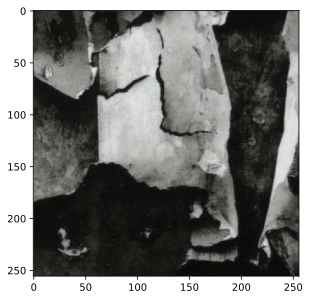

In [28]:
plt.imshow(torch.permute(dataset[10][1], (1, 2, 0)))

In [29]:
try_indices = list(range(4))
try_dataset = Subset(dataset, try_indices)

In [30]:
# dataloader = DataLoader(dataset=dataset, 
#                         batch_size=BATCH_SIZE, 
#                         collate_fn=contrastive_collator,
#                         shuffle=True)

dataloader = DataLoader(dataset=try_dataset, 
                        batch_size=BATCH_SIZE, 
                        collate_fn=contrastive_collator,
                        shuffle=True)

### Инициализация модели

In [47]:
NUM_EPOCHS = 2
SEED = 42
VERBOSE_STEP = 1
SAVE_STEP = 1
pretrained_epoch = 45
experiment_number_saved_models = 10
experiment_number = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
encoder = PretrainedVGG19Encoder()
decoder = VGG19Decoder()
transfer_block = BaseTransferBlock()

In [49]:
encoder_path = torch.load("vgg_normalised.pth", weights_only=True)
decoder_path = torch.load("decoder_iter_160000.pth", weights_only=True)
transform_path = torch.load("transformer_iter_160000.pth", weights_only=True)

In [50]:
for old_key, new_key in zip(list(encoder_path.keys()), list(encoder.state_dict().keys())):
    encoder_path[new_key] = encoder_path.pop(old_key)

for old_key, new_key in zip(list(decoder_path.keys()), list(decoder.state_dict().keys())):
    decoder_path[new_key] = decoder_path.pop(old_key)

for old_key, new_key in zip(list(transform_path.keys()), list(transfer_block.state_dict().keys())):
    transform_path[new_key] = transform_path.pop(old_key)

In [51]:
encoder.load_state_dict(encoder_path)
decoder.load_state_dict(decoder_path)
transfer_block.load_state_dict(transform_path)

<All keys matched successfully>

In [52]:
# Initial model

model = RAST(encoder, decoder, transfer_block).to(device)
left_discriminator = MultiDiscriminator().to(device)
right_discriminator = MultiDiscriminator().to(device)
optimizer = torch.optim.Adam(model.parameters())
optimizer_leftd = torch.optim.Adam(left_discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_rightd = torch.optim.Adam(right_discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))
scheduler = Scheduler(optimizer=optimizer) 
scheduler_leftd = Scheduler(optimizer_leftd)
scheduler_rightd = Scheduler(optimizer_rightd)

In [37]:
class Color:
    CYAN = '\033[0;46m'
    GREEN = '\033[0;42m'
    OFF = '\033[0;0m'

count = 0
all_count = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        count += param.numel()
    all_count += param.numel()
    # print(f"{name}: {param.numel()}")
print(f'\n{Color.GREEN}Model parameters requiring gradient count: {count}{Color.OFF}')
print(f'\n{Color.CYAN}Model parameters count: {all_count}{Color.OFF}')


Model parameters requiring gradient count: 8179907

Model parameters count: 28204303


In [38]:
### Pretrained

# For train
saved_models_path = Path(f'./saved_models/exp#{experiment_number_saved_models}')
save_path_experiment = Path(f'./saved_models/exp#{experiment_number}')
log_dir_experiment = Path(f'./logs/exp#{experiment_number}/run')
logtable_path_experiment = Path(f'./log_tables/exp#{experiment_number}')
save_path_experiment.mkdir(exist_ok=True, parents=True)
log_dir_experiment.mkdir(exist_ok=True, parents=True)
logtable_path_experiment.mkdir(exist_ok=True, parents=True)
saved_models_path.mkdir(exist_ok=True, parents=True)
log_tb_name_experiment = f"/experiment_{experiment_number}"

# For inference
savefig_dir_experiment = Path(f'./saved_results/exp#{experiment_number}')
savefig_dir_experiment.mkdir(exist_ok=True, parents=True)

# model.load_state_dict(torch.load(f'{saved_models_path}/model_epoch_{pretrained_epoch}.pth', weights_only=True))
# model.get_loss_oracle().load_state_dict(torch.load(f'{saved_models_path}/loss_oracle_epoch_{pretrained_epoch}.pth', weights_only=True))
# left_discriminator.load_state_dict(torch.load(f'{saved_models_path}/left_discriminator_epoch{pretrained_epoch}.pth', weights_only=True))
# right_discriminator.load_state_dict(torch.load(f'{saved_models_path}/right_discriminator_epoch{pretrained_epoch}.pth', weights_only=True))
# optimizer.load_state_dict(torch.load(f'{saved_models_path}/optimizer_epoch_{pretrained_epoch}.pth', weights_only=True))
# optimizer_leftd.load_state_dict(torch.load(f'{saved_models_path}/optimizer_leftd_epoch_{pretrained_epoch}.pth', weights_only=True))
# optimizer_rightd.load_state_dict(torch.load(f'{saved_models_path}/optimizer_rightd_epoch_{pretrained_epoch}.pth', weights_only=True))
# scheduler.load_state_dict(torch.load(f'{saved_models_path}/scheduler_epoch_{pretrained_epoch}.pth', weights_only=True))
# scheduler_leftd.load_state_dict(torch.load(f'{saved_models_path}/scheduler_leftd_epoch_{pretrained_epoch}.pth', weights_only=True))
# scheduler_rightd.load_state_dict(torch.load(f'{saved_models_path}/scheduler_rightd_epoch_{pretrained_epoch}.pth', weights_only=True))

### Обучение модели

In [42]:
# try_dataloader.dataset.set_transform(train_transform, train_transform)
trainer = Trainer(model=model, 
                  left_discriminator=left_discriminator,
                  right_discriminator=right_discriminator,
                  dataloader=dataloader, 
                  optimizer=optimizer, 
                  optimizer_leftd=optimizer_leftd, 
                  optimizer_rightd=optimizer_rightd, 
                  scheduler=scheduler, 
                  scheduler_leftd=scheduler_leftd, 
                  scheduler_rightd=scheduler_rightd,
                  last_epoch=0,
                  seed=SEED,
                  num_epochs=NUM_EPOCHS,
                  save_path=save_path_experiment,
                  logtable_path=logtable_path_experiment,
                  log_dir=log_dir_experiment,
                  log_tb_name=log_tb_name_experiment,
                  verbose=True,
                  verbose_step=VERBOSE_STEP,
                  device=device,
                  save_step=SAVE_STEP)

In [43]:
losses = trainer(train_left_gan=False, train_right_gan=False)

Training has been started...



Epoch[1] | Loss[50.605] | Training time[40.957] ]
Memory data | Allocated: 329403392 | Reserved: 658505728

Parameters are saved



Epoch[2] | Loss[46.562] | Training time[44.710] ]
Memory data | Allocated: 329387008 | Reserved: 681574400

Parameters are saved



### Инференс модели

In [44]:
inference_number = 15
inference_indices = np.arange(0, 10)

In [54]:
class Inferencer:

    def __init__(self, model, dataset, device, verbose=True):
        self.model = model
        self.dataset = dataset
        self.device = device
        self.verbose = verbose
        self.model.eval()
        self.avg_inference_time = None
        self.content_images = []
        self.style_images = []
        self.stylized_images = []

    @torch.no_grad()
    def __call__(self, idx_list = None):
        self.model.eval()
        average_time = 0.0
        self.content_images = []
        self.style_images = []
        self.stylized_images = []
        idx_list = idx_list if idx_list is not None else np.arange(len(self.dataset))
        for idx in progress_bar(idx_list, total=len(idx_list), comment="Inference is in progress...", leave=self.verbose):
            self.content_images.append(self.dataset[idx][0])
            self.style_images.append(self.dataset[idx][1])
            time_start = time()
            stylized_image = self.model(self.dataset[idx][0].unsqueeze(0).to(self.device), 
                                        self.dataset[idx][1].unsqueeze(0).to(self.device))
            average_time += time() - time_start
            self.stylized_images.append(stylized_image)

        average_time /= len(idx_list)
        self.avg_inference_time = average_time

    def draw(self, save_path=None):
        # Проверяем, что списки имеют одинаковую длину
        num_images = min(len(self.content_images), len(self.style_images))
        
        # Размер сетки и отступы
        fig = plt.figure(figsize=(12, 3 * num_images))
        gs = gridspec.GridSpec(num_images + 1, 3, height_ratios=[0.1] + [1] * num_images)
        gs.update(wspace=0.05, hspace=0.05)  # Минимизируем промежутки между изображениями
        
        # Названия столбцов
        titles = ["Стилизация", "Контент", "Стиль"]
        for i, title in enumerate(titles):
            ax = fig.add_subplot(gs[0, i])
            ax.text(0.5, 0.5, title, ha='center', va='center', fontsize=14, fontweight='bold')
            ax.axis("off")
        
        # Заполняем сетку изображениями
        for idx in range(num_images):
            stylized_img = np.clip(self.stylized_images[idx][0].permute(1, 2, 0).detach().cpu().numpy(), 0, 1)
            content_img = self.content_images[idx].permute(1, 2, 0)
            style_img = self.style_images[idx].permute(1, 2, 0)
            
            for col, image in enumerate([stylized_img, content_img, style_img]):
                ax = fig.add_subplot(gs[idx + 1, col])
                ax.imshow(image)
                ax.axis("off")  # Убираем оси
        if save_path is not None:
            plt.savefig(save_path, format='svg', bbox_inches='tight')
        plt.show()

In [55]:
dataset.set_transform(inference_transform, inference_transform)
inferecer = Inferencer(model, dataset, device)
inferecer(inference_indices)
inferecer.draw(save_path=f"{savefig_dir_experiment}/saved_image{inference_number}.svg")

In [54]:
inferecer(np.arange(30000, 30010))

In [55]:
print(f'Average inference time is {inferecer.avg_inference_time}')
inferecer.draw()

Average inference time is 0.1087730884552002


In [57]:
inference_idx = 30008

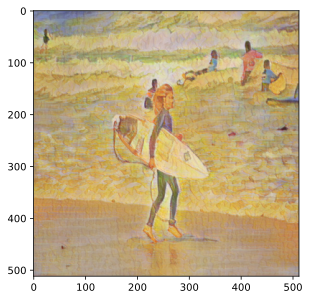

In [58]:
model.eval()
content, style = dataset[inference_idx]
stylized_image = model(content.unsqueeze(0).to(device), style.unsqueeze(0).to(device))
# plt.imshow(content.permute(1, 2, 0))
plt.imshow(np.clip(stylized_image[0].permute(1, 2, 0).detach().cpu().numpy(), 0, 1))